In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

In [ ]:
df=pd.read_csv('AMD.csv', parse_dates=['Date'],index_col=['Date'])

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-17,0.000000,3.302083,3.125000,3.145833,3.145833,219600
1980-03-18,0.000000,3.125000,2.937500,3.031250,3.031250,727200
1980-03-19,0.000000,3.083333,3.020833,3.041667,3.041667,295200
1980-03-20,0.000000,3.062500,3.010417,3.010417,3.010417,159600
1980-03-21,0.000000,3.020833,2.906250,2.916667,2.916667,130800
...,...,...,...,...,...,...
2020-03-26,45.779999,47.500000,45.400002,47.500000,47.500000,73680200
2020-03-27,46.320000,47.980000,45.900002,46.580002,46.580002,74599200
2020-03-30,47.240002,48.459999,46.660000,47.860001,47.860001,68486600


# Nomor 1a

Saham AMD memiliki harga terendahnya pada tahun 2015 dengan harga 1.62, sedangkan harga tertinggi pada tahun 2020 dengan harga 58.9.

In [ ]:
# Menemukan nilai minimum dan maksimum dari kolom 'Close'
min_value = df['Close'].min()
max_value = df['Close'].max()

# Menemukan tanggal terjadinya nilai minimum dan maksimum
min_date = df['Close'].idxmin()
max_date = df['Close'].idxmax()

print("Nilai Minimum:", min_value, "pada tanggal:", min_date)
print("Nilai Maksimum:", max_value, "pada tanggal:", max_date)

Nilai Minimum: 1.6200000047683716 pada tanggal: 2015-07-27 00:00:00
Nilai Maksimum: 58.900001525878906 pada tanggal: 2020-02-19 00:00:00


seiiring berjalannya waktu, harga saham AMD mengalami fluktuasi yang menyebabkan banyaknya harga yang terindikasi sebagai outliers berdasarkan IQR nya. sebesar 4.5% dari keseluruhan harga merupakan outliers. dimana outliers dalam kasus ini adalah harga saham yang diatas rata-rata.

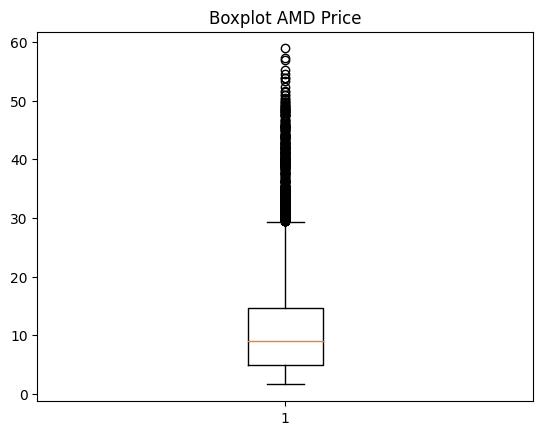

Jumlah data : 10098
Jumlah outliers : 461
Persentase outliers : 4.5652604476133885 %


In [ ]:
close_prices = df['Close']

Q1 = np.percentile(close_prices, 25)
Q3 = np.percentile(close_prices, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = close_prices[(close_prices < lower_bound) | (close_prices > upper_bound)]
plt.boxplot(close_prices)
plt.title('Boxplot AMD Price')
plt.show()
print("Jumlah data :", len(close_prices))
print("Jumlah outliers :", len(outliers))
print("Persentase outliers :", len(outliers)/len(close_prices)*100,"%")

Berdasarkan plot dekomposisi dibawah ini terdapat beberapa insight yakni :


**Trend:**

Tren jangka panjang menunjukkan pertumbuhan yang signifikan dari 1980 hingga 2020.
Terdapat beberapa siklus bull dan bear market yang jelas, dengan puncak-puncak utama sekitar tahun 2000, 2007, dan 2020.
Pertumbuhan paling tajam terlihat dari 2015 ke 2020.


**Seasonal:**

Pola musiman terlihat lebih jelas dengan periode 252 hari (total hari close harga saham per tahunnya).
Terdapat fluktuasi reguler yang mungkin mencerminkan siklus tahunan dalam perdagangan saham.
Amplitudo pola musiman relatif kecil dibandingkan dengan tren keseluruhan, menunjukkan pola musiman memiliki dampak yang relatif kecil terhadap pergerakan harga keseluruhan.


**Residual:**

Komponen residual menunjukkan volatilitas yang bervariasi sepanjang waktu.
Periode volatilitas tinggi terlihat sekitar tahun 2000 karena dilansir dari wikipedia, diawal tahun 2000 terjadi resisi ekonomi dimana terjadinya penurunan besar aktivitas perekonomian yang terutama terjadi di negara-negara maju, krisis moneter 2008, dan wabah COVID-19 yang menyebar secara global pada tahun 2019.

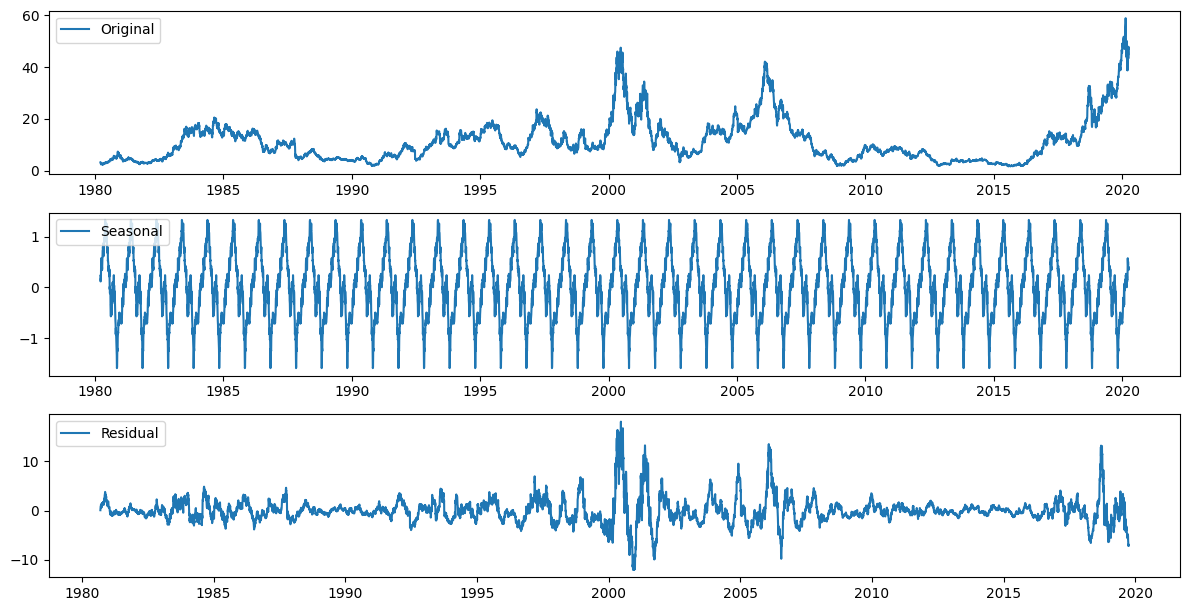

In [ ]:
result = seasonal_decompose(df['Close'], model='additive', period=252)
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Nilai statistik dibawah ini dibuat untuk menguji hipotesis awal dimana :
- H0 = Data berisi unit root
- H1 = Data tidak berisi unit root

Jika terdapat unit root dalam data, maka data tidak stasioner (tidak memiliki mean atau varians yang konstan).

significant level pada ADF tanpa parameter tambahan adalah 0.05 (-2.862)

1. ADF Statistic (-2.83) > Significant Level (-2.86), maka kita tidak memiliki cukup bukti untuk menolak H0.
2. P-Value (0.055) > Significant Level (0.05), maka kita tidak memiliki cukup bukti untuk menolak H0.

Kesimpulannya, data time series yang kita miliki bersifat **stasioner** dimana data memiliki mean atau varians yang konstan.

In [ ]:
result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.8258497430007226
p-value: 0.054675132600285205


Splitting Time Series Dataset

In [ ]:
df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df.columns

Index(['Close'], dtype='object')

In [ ]:
def create_windows(data, window_size, horizon):
    windows = []
    for i in range(len(data) - window_size - horizon + 1):
        input_window = data.iloc[i:i+window_size]['Close'].values
        output_window = data.iloc[i+window_size:i+window_size+horizon]['Close'].values
        windows.append((input_window, output_window))
    return windows

df_windows = create_windows(df, window_size=5, horizon=1)

def split_data(windows, train_ratio, val_ratio):
    n = len(windows)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    train_data = windows[:train_end]
    val_data = windows[train_end:val_end]
    test_data = windows[val_end:]

    return train_data, val_data, test_data

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train, val, test = split_data(df_windows, train_ratio, val_ratio)

print(f"AAPL Data - Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")
def prepare_data(windows):
    X = np.array([window[0] for window in windows])
    y = np.array([window[1] for window in windows])
    return X, y

X_train, y_train = prepare_data(train)
X_val, y_val = prepare_data(val)
X_test, y_test = prepare_data(test)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

AAPL Data - Train: 8074, Validation: 1009, Test: 1010


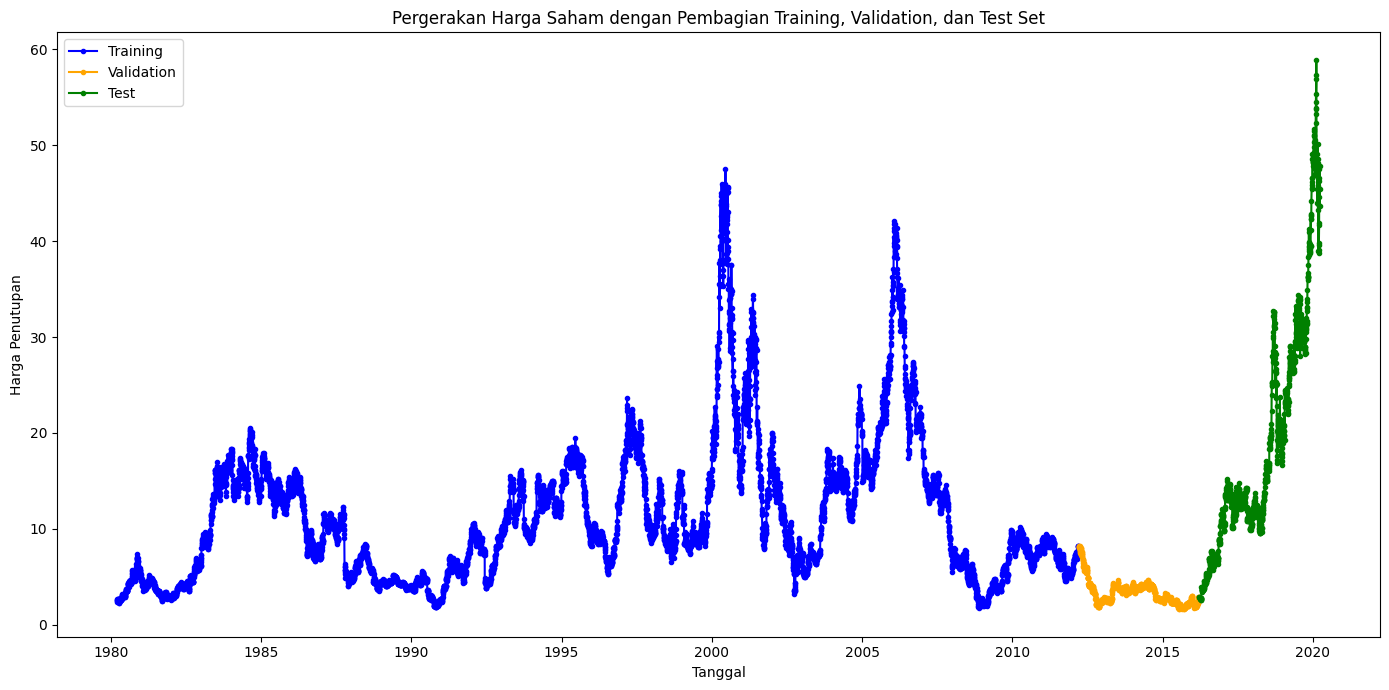

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df.index[:len(y_train)], y_train, marker='.', label='Training', color='blue')
plt.plot(df.index[len(y_train):len(y_train)+len(y_val)], y_val, marker='.', label='Validation', color='orange')
plt.plot(df.index[len(y_train)+len(y_val):len(y_train)+len(y_val)+len(y_test)], y_test, marker='.', label='Test', color='green')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.title('Pergerakan Harga Saham dengan Pembagian Training, Validation, dan Test Set')
plt.legend()
plt.tight_layout()
plt.show()

# Nomor 1b

In [ ]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(5, 1), activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mae', metrics=RootMeanSquaredError())
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 50)                10400     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val)
                    #callbacks=[early_stopping]
                    )

Epoch 1/50
253/253 [==============================] - 4s 7ms/step - loss: 1.4656 - root_mean_squared_error: 3.3744 - val_loss: 0.1441 - val_root_mean_squared_error: 0.2088
Epoch 2/50
253/253 [==============================] - 1s 5ms/step - loss: 0.4221 - root_mean_squared_error: 0.6720 - val_loss: 0.1177 - val_root_mean_squared_error: 0.1621
Epoch 3/50
253/253 [==============================] - 1s 5ms/step - loss: 0.3975 - root_mean_squared_error: 0.6373 - val_loss: 0.1105 - val_root_mean_squared_error: 0.1595
Epoch 4/50
253/253 [==============================] - 1s 6ms/step - loss: 0.3687 - root_mean_squared_error: 0.6049 - val_loss: 0.1350 - val_root_mean_squared_error: 0.1847
Epoch 5/50
253/253 [==============================] - 1s 5ms/step - loss: 0.3585 - root_mean_squared_error: 0.5885 - val_loss: 0.1079 - val_root_mean_squared_error: 0.1531
Epoch 6/50
253/253 [==============================] - 1s 6ms/step - loss: 0.3519 - root_mean_squared_error: 0.5763 - val_loss: 0.1035 - val_

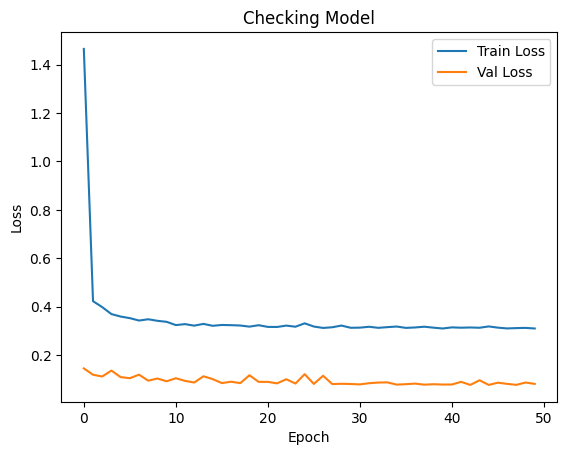

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.title("Checking Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")

32/32 [==============================] - 0s 3ms/step
RMSE: 0.9363
MAE: 0.5546
MAPE: 2.8488%


# Nomor 1c

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(units=200, activation='relu', return_sequences=True), input_shape=(5, 1)))
#model.add(Bidirectional(LSTM(units=100, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(units=100, activation='relu')))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mae', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirect  (None, 5, 400)            323200    
 ional)                                                          
                                                                 
 bidirectional_17 (Bidirect  (None, 200)               400800    
 ional)                                                          
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 724201 (2.76 MB)
Trainable params: 724201 (2.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    #batch_size=64,
                    validation_data=(X_val, y_val)
                    #callbacks=[early_stopping]
                    )

Epoch 1/50
253/253 [==============================] - 20s 53ms/step - loss: 0.8403 - root_mean_squared_error: 2.1026 - val_loss: 0.1302 - val_root_mean_squared_error: 0.1772
Epoch 2/50
253/253 [==============================] - 13s 52ms/step - loss: 0.4770 - root_mean_squared_error: 0.7594 - val_loss: 0.1772 - val_root_mean_squared_error: 0.2217
Epoch 3/50
253/253 [==============================] - 13s 51ms/step - loss: 0.4396 - root_mean_squared_error: 0.7010 - val_loss: 0.1243 - val_root_mean_squared_error: 0.1690
Epoch 4/50
253/253 [==============================] - 13s 52ms/step - loss: 0.3893 - root_mean_squared_error: 0.6293 - val_loss: 0.1758 - val_root_mean_squared_error: 0.2184
Epoch 5/50
253/253 [==============================] - 13s 53ms/step - loss: 0.3714 - root_mean_squared_error: 0.6043 - val_loss: 0.1113 - val_root_mean_squared_error: 0.1611
Epoch 6/50
253/253 [==============================] - 14s 56ms/step - loss: 0.3614 - root_mean_squared_error: 0.5887 - val_loss: 0

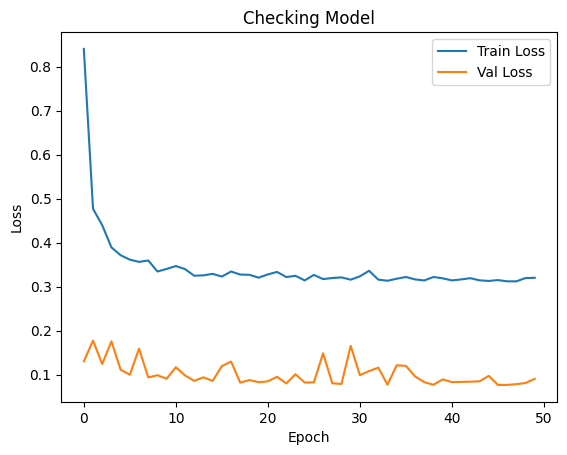

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.title("Checking Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Nomor 1d

In [ ]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")

32/32 [==============================] - 1s 14ms/step
RMSE: 0.9078
MAE: 0.5335
MAPE: 2.7425%


32/32 [==============================] - 0s 13ms/step


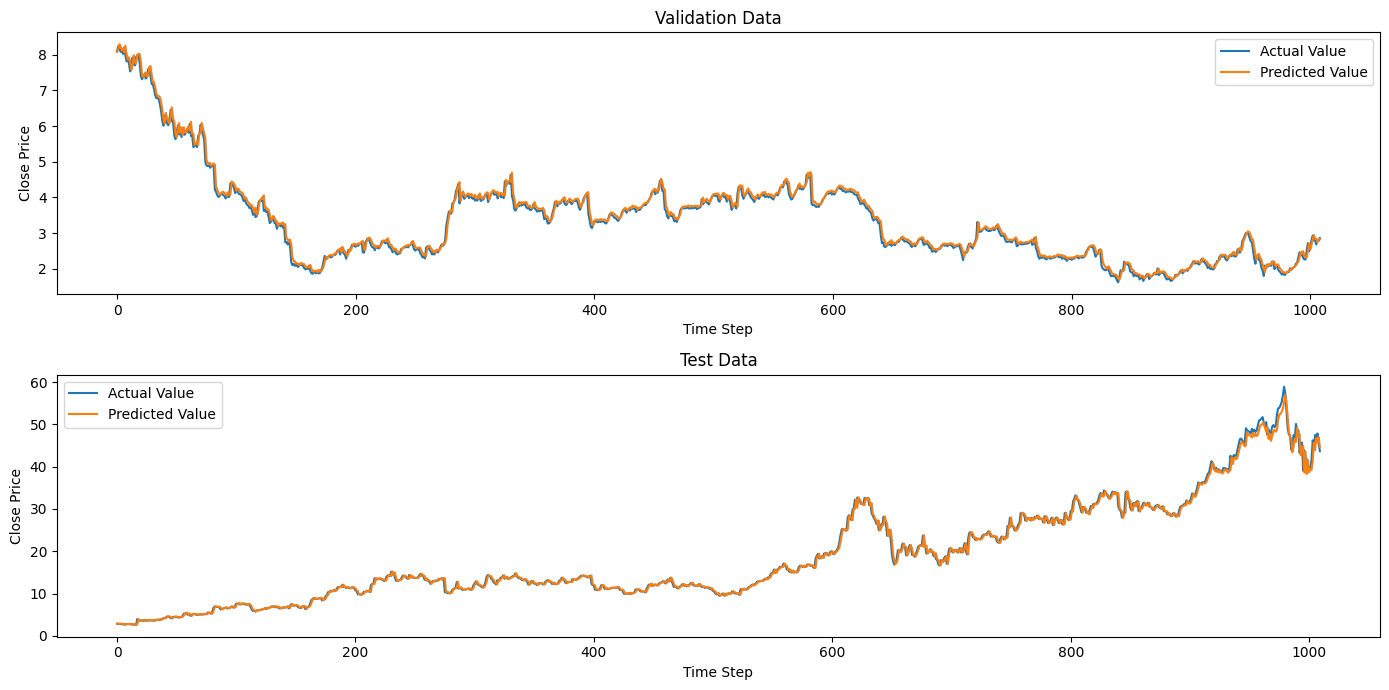

In [ ]:
import matplotlib.pyplot as plt

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(y_val, label='Actual Value')
plt.plot(y_val_pred, label='Predicted Value')
plt.title('Validation Data')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual Value')
plt.plot(y_test_pred, label='Predicted Value')
plt.title('Test Data')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()

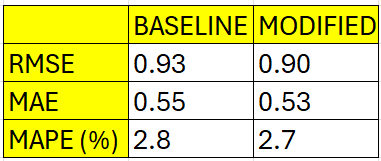

**Performa Metrik:**

Kedua model menunjukkan performa yang sangat baik dengan nilai RMSE dan MAE yang sangat rendah, menunjukkan bahwa keduanya mampu memberikan prediksi yang dekat dengan nilai sebenarnya.
MAPE: Model modifikasi memiliki sedikit penurunan dalam MAPE dibandingkan dengan baseline, menunjukkan bahwa model modifikasi sedikit lebih baik dalam menghasilkan prediksi dengan kesalahan relatif yang lebih rendah.


**Arsitektur Model:**

Penggunaan dua layer Bidirectional LSTM pada model modifikasi dapat membantu dalam menangkap pola dan dependensi dalam data time series yang kompleks seperti harga saham AMD. Hal ini dapat memberikan keuntungan tambahan dalam memahami arah perubahan harga saham.


**Kesimpulan:**

Meskipun perbedaan dalam metrik evaluasi antara kedua model tidak terlalu besar, model modifikasi menunjukkan sedikit peningkatan dalam beberapa metrik, terutama MAPE, yang merupakan ukuran kesalahan relatif. Ini menunjukkan bahwa arsitektur yang lebih kompleks dengan Bidirectional LSTM dapat memberikan sedikit keunggulan dalam memodelkan time series seperti harga saham AMD.